# Reproducing Pober+2014

In this demo, we are going to reproduce many of the results of [Pober+2014](https://arxiv.org/pdf/1310.7031.pdf), which looked at the sensitivity of a "concept HERA" (which differs somewhat from the final instrument), as well as a few other well-known arrays.

The "reproduction" here is not expected to be exact -- there are several small tweaks made in the current version that are not present in the code used for the original paper, for example cosmological calculations are done with astropy instead of approximate fitting functions. Nevertheless, we show that the signal-to-noise estimates in any given $k$-bin are consistent to within 15% of the original.

In [1]:
import py21cmsense as p21c
from astropy import units as un
from astropy.cosmology.units import littleh
import matplotlib.pyplot as plt
import numpy as np

In [2]:
p21c.config.COSMO = p21c.config.COSMO.clone(H0=70.0, Om0=0.266)

## HERA

P14 used a concept version of HERA that was a perfect hexagon (with no splits), with 547
elements and no outriggers. Let's create such an array:

In [3]:
hera_ants = p21c.antpos.hera(hex_num=14)

In [4]:
hera_ants.shape

(547, 3)

We will reproduce the results at $z=9.5$ (the default case in P14). Note that we use a dish size that is slightly 
different that that of P14, because the important thing is to match the beam width (which scales linearly
with frequency):

In [5]:
beam = p21c.GaussianBeam(frequency=1420*un.MHz/(1 + 9.5), dish_size=13.919*un.m)

In [6]:
beam.fwhm.to(un.deg)

<Quantity 9.64976265 deg>

What is the beam-crossing time? This is given as "about 40min" by P14. We obtain it as:

In [7]:
beam.fwhm.to(un.deg).value*24*60/360

38.5990505880113

As a check on whether our GaussianBeam model is similar to the assumed beam in P14, 
we check the FWHM at 150MHz, quoted as 8.7deg in Table 1 of P14:

In [8]:
p21c.GaussianBeam(frequency=150*un.MHz, dish_size=13.919*un.m).fwhm.to(un.deg)

<Quantity 8.70010347 deg>

This is very close to the quoted value.

Now, let's create the HERA Observatory model. Here, we set the receiver temperature to 100K,
as per Table 1 of P14. We also set the latitude of the instrument to that of Green Bank (38:25:59.24),
which was the assumed location of HERA in P14:

In [9]:
hera = p21c.Observatory(
    antpos=hera_ants,
    beam=beam,
    latitude=0.6707845*un.rad,
    Trcv=100*un.K,
)

Now, set up the observation itself. Here we assume a sky temperature model of 
$351{\rm K} (\nu/150 {\rm MHz})^{-2.55}$, as described in S2.1.2 of P14. 

Furthermore, we set the number of days of observation to 180, with 6 hours per night. 
We also set the "coherent observing time" to its default of the beam crossing time, 
which is about 40min as per the above calculation.

Finally, as per S3.1.2 of P14, we use 8MHz of bandwidth, with 81 channels (providing
0.1 MHz channel width).

In [10]:
obs = p21c.Observation(
    observatory=hera,
    tsky_amplitude=351*un.K,
    tsky_ref_freq=150*un.MHz,
    spectral_index=2.55,
    n_days=180,
    time_per_day=6*un.hour,
    bandwidth=8*un.MHz,
    n_channels=81,
)

In [11]:
obs.uv_coverage.shape

gridding baselines: 100%|██████████| 2106/2106 [00:00<00:00, 13727.13baselines/s]


(53, 53)

In [12]:
obs.frequency

<Quantity 135.23809524 MHz>

We make sure the observation duration is close to 40 minutes:

In [14]:
obs.obs_duration.to(un.min)

<Quantity 38.59905059 min>

Now construct the sensitivity calculation:

In [57]:
sense_optimistic = p21c.PowerSpectrum(
    observation=obs,
    foreground_model='optimistic',
    horizon_buffer=0.0 *littleh/un.Mpc,
    theory_model=p21c.theory.Legacy21cmFAST(),
)

In [58]:
sense1d = sense_optimistic.calculate_sensitivity_1d(thermal=True, sample=True)

averaging to 1D: 100%|██████████| 243/243 [00:01<00:00, 156.67kperp-bins/s]


### Plot analogs of Fig. 5 from Pober+2014

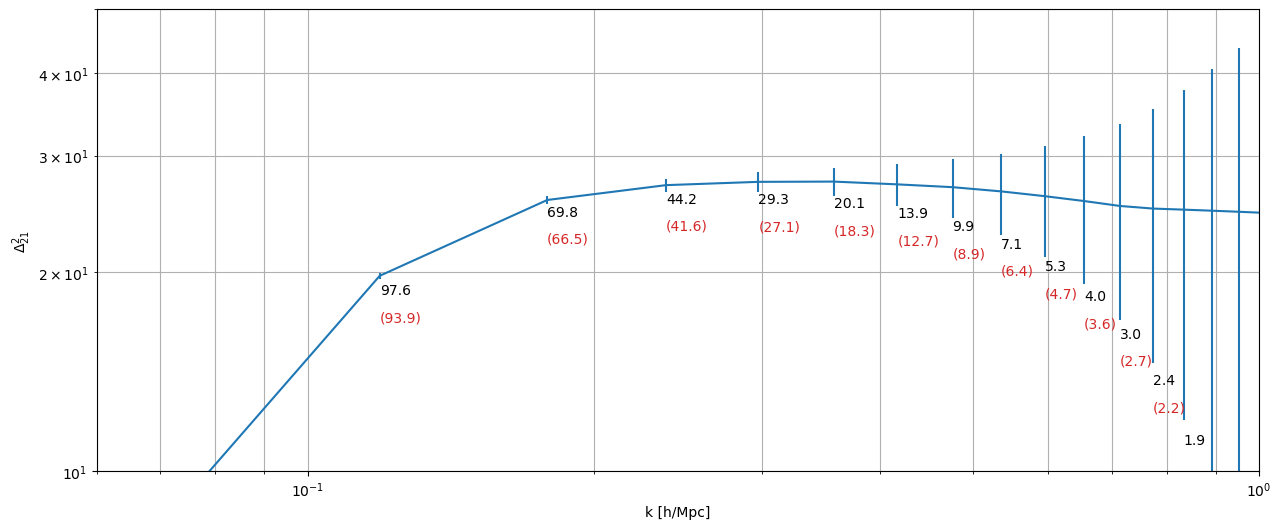

In [59]:
snr_opt_pober14 = [
    0, 93.9, 66.5, 41.6, 27.1, 18.3, 12.7, 8.9, 6.4, 4.7, 3.6, 2.7, 2.2
]

plt.figure(figsize=(15, 6))
plt.errorbar(
    sense_optimistic.k1d, 
    sense_optimistic.delta_squared,
    sense1d
)
plt.xlim(0.06, 1)
plt.ylim(10, 50)
plt.xscale('log')
plt.yscale('log')

for i, kk in enumerate(sense_optimistic.k1d):
    sig = sense_optimistic.delta_squared[i] / sense1d[i]
    yloc = sense_optimistic.delta_squared[i].value - sense1d[i].value - 1
    if sig > 1 and yloc > 10:
        plt.text(kk.value, yloc,  f"{sig:.1f}")
        if i < len(snr_opt_pober14):
            plt.text(kk.value, yloc/1.1, f"({snr_opt_pober14[i]:.1f})", color='C3')
plt.grid(which='both')
plt.xlabel("k [h/Mpc]")
plt.ylabel("$\Delta^2_{21}$");

In [23]:
sense_moderate = sense_optimistic.clone(foreground_model='moderate', horizon_buffer=0.1 *littleh/un.Mpc)

In [24]:
sense1d_moderate = sense_moderate.calculate_sensitivity_1d(thermal=True, sample=True)

averaging to 1D: 100%|██████████| 243/243 [00:01<00:00, 156.45kperp-bins/s]


/home/steven/work/eor/21cmSense/py21cmsense/theory.py:142: UserWarning: Extrapolating above the simulated theoretical k: 3.3749883159994045 > 2.192064
  warnings.warn(


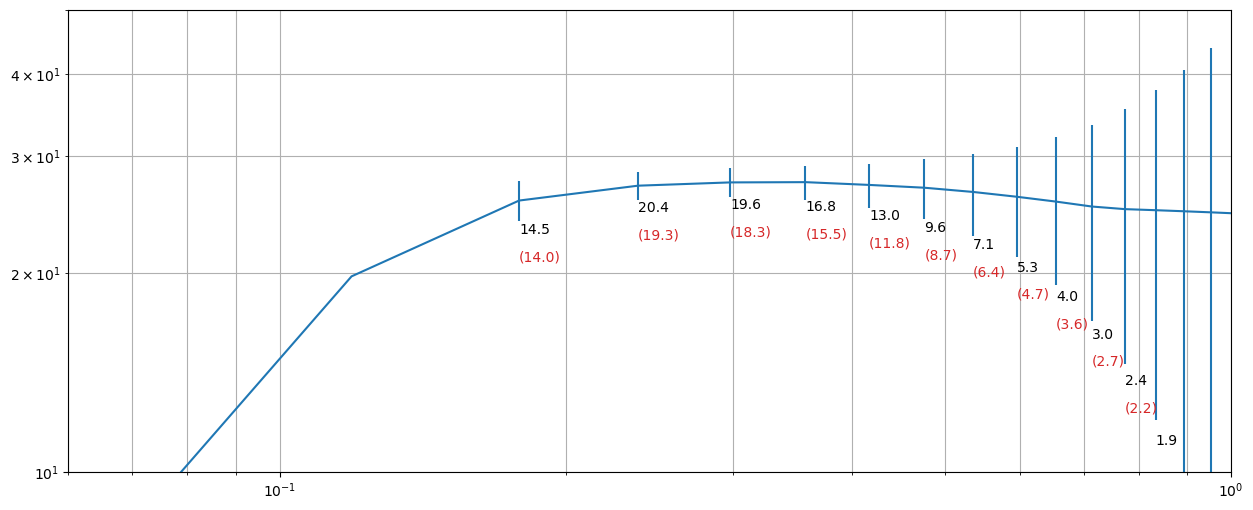

In [55]:
snr_mod_pober14 = [
    0, 0, 14.0, 19.3, 18.3, 15.5, 11.8, 8.7, 6.4, 4.7, 3.6, 2.7, 2.2
]
plt.figure(figsize=(15, 6))

plt.errorbar(
    sense_moderate.k1d, 
    sense_moderate.delta_squared,
    sense1d_moderate
)
plt.xlim(0.06, 1)
plt.ylim(10, 50)
plt.xscale('log')
plt.yscale('log')

for i, kk in enumerate(sense_moderate.k1d):
    sig = sense_moderate.delta_squared[i] / sense1d_moderate[i]
    yloc = sense_moderate.delta_squared[i].value - sense1d_moderate[i].value - 1
    if sig > 1 and yloc > 10:
        plt.text(kk.value, yloc,  f"{sig:.1f}")
        if i < len(snr_opt_pober14):
            plt.text(kk.value, yloc/1.1, f"({snr_mod_pober14[i]:.1f})", color='C3')

plt.grid(which='both')

In [27]:
sense_pessimistic = sense_moderate.clone(
    observation=obs.clone(coherent=False)
)

In [28]:
sense1d_pess = sense_pessimistic.calculate_sensitivity_1d(thermal=True, sample=True)

averaging to 1D: 100%|██████████| 243/243 [00:01<00:00, 158.63kperp-bins/s]


/home/steven/work/eor/21cmSense/py21cmsense/theory.py:142: UserWarning: Extrapolating above the simulated theoretical k: 3.3749883159994045 > 2.192064
  warnings.warn(


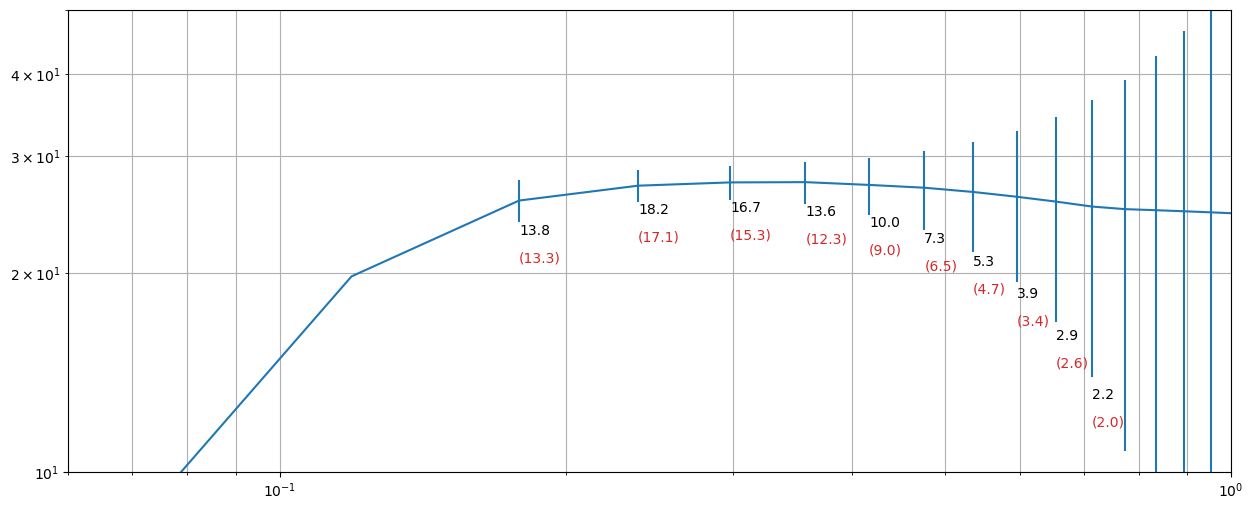

In [56]:
snr_pess_pober14 = [
    0, 0, 13.3, 17.1, 15.3, 12.3, 9.0, 6.5, 4.7, 3.4, 2.6, 2.0
]
plt.figure(figsize=(15, 6))

plt.errorbar(
    sense_pessimistic.k1d, 
    sense_pessimistic.delta_squared,
    sense1d_pess
)
plt.xlim(0.06, 1)
plt.ylim(10, 50)
plt.xscale('log')
plt.yscale('log')

for i, kk in enumerate(sense_pessimistic.k1d):
    sig = sense_pessimistic.delta_squared[i] / sense1d_pess[i]
    yloc = sense_pessimistic.delta_squared[i].value - sense1d_pess[i].value - 1
    if sig > 1 and yloc > 10:
        plt.text(kk.value, yloc,  f"{sig:.1f}")
        if i < len(snr_opt_pober14):
            plt.text(kk.value, yloc/1.1, f"({snr_pess_pober14[i]:.1f})", color='C3')

plt.grid(which='both')

It seems that the default implementation of the new 21cmSense is everywhere a little less
significant than the original implementation. It is unclear exactly where this difference
comes from, but there are lots of small differences in the implementations -- of which the
newer version is typically *more* accurate. In any case, the overall significance levels
are comparable, and certainly have the same *shape* as the original.

## Tests

From here, we are simply performing some tests to ensure that the results stay 
roughly consistent (within 15%) as new features/fixes are added.

In [35]:
snr_pess = sense_pessimistic.delta_squared / sense1d_pess
if not np.allclose(snr_pess[:len(snr_pess_pober14)], snr_pess_pober14, atol=0, rtol=0.15):
    raise ValueError("The SNR for the pessimistic case has changed by more than 30%!")

if not np.all(np.diff(snr_pess)[len(snr_pess_pober14):]<=0):
    raise ValueError("The SNR for the pessimistic case is increasing at high k :/")

In [42]:
snr_mod = sense_moderate.delta_squared / sense1d_moderate
if not np.allclose(snr_mod[:len(snr_mod_pober14)],snr_mod_pober14, atol=0, rtol=0.15):
    raise ValueError("The SNR for the moderate case has changed by more than 15%!")

if not np.all(np.diff(snr_mod)[len(snr_mod_pober14):]<=0):
    raise ValueError("The SNR for the moderate case is increasing at high k :/")

In [67]:
snr_opt = sense_optimistic.delta_squared / sense1d
if not np.allclose(snr_opt[1:len(snr_opt_pober14)],snr_opt_pober14[1:], atol=0, rtol=0.15):
    raise ValueError("The SNR for the optimistic case has changed by more than 15%!")

if not np.all(np.diff(snr_opt)[len(snr_opt_pober14)+1:]<=0):
    raise ValueError("The SNR for the optimistic case is increasing at high k :/")

/home/steven/work/eor/21cmSense/py21cmsense/theory.py:142: UserWarning: Extrapolating above the simulated theoretical k: 3.3749883159994045 > 2.192064
  warnings.warn(


Also make sure that opt is better than moderate is better than pessimistic:

In [45]:
if not np.all(snr_opt >= snr_mod):
    raise ValueError("snr_opt must be better than snr_mod!")

if not np.all(snr_mod >= snr_pess):
    raise ValueError("snr_mod must be better than snr_pess!")


Make sure we have the same "shape" as the original:

In [46]:
if not np.all(np.sign(np.diff(snr_pess_pober14))==np.sign(np.diff(snr_pess[:len(snr_pess_pober14)]))):
    raise ValueError("pessimistic case has different shape to Pober+14")

if not np.all(np.sign(np.diff(snr_mod_pober14))==np.sign(np.diff(snr_mod[:len(snr_mod_pober14)]))):
    raise ValueError("moderate case has different shape to Pober+14")

if not np.all(np.sign(np.diff(snr_opt_pober14))==np.sign(np.diff(snr_opt[1:len(snr_opt_pober14)+1]))):
    raise ValueError("optimistic case has different shape to Pober+14")

